In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

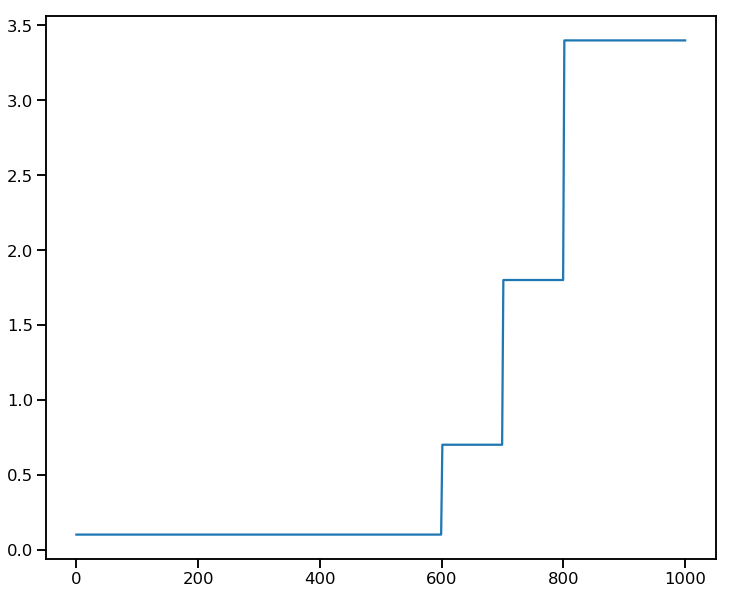

In [2]:
from ipywidgets import widgets, interact
from IPython.display import display
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("talk")
from scipy.integrate import odeint


def homeostat(y, x, k = .2, K_d = 0.1, n=6):
    rate = x - k*y**n/(y**n+K_d**n)-y
    return rate

def signal_limiter(y, x, k=.8, n=5):
    rate = x - k*y**n-y
    return rate

# System of ODEs
def adaptive_system(Y, x, k=0.05, n=5, tau=0.01):
    beta, y = Y
    rate_y = x*(1-beta)-y
    rate_beta = tau*(y-k*beta)
    return [rate_beta, rate_y]

def transient_generator(Y, x, k1=0.8, k2=0.05, n=5, tau=0.01):
    beta, y = Y
    rate_y = x-y*k1*beta**n-y
    rate_beta = tau*(y-k2*beta)
    return [rate_beta, rate_y]
    
class Signal:
    def __init__(self, t):
        self.time = np.linspace(0, t, 500)
        self.signal = np.zeros_like(self.time)
        
    def Step(self, steptime, stepsize):
        self.signal += stepsize*np.heaviside(self.time-steptime, steptime)

    def Pulse(self, pulsetime, pulseduration, pulsesize):
        self.signal += self.Step(pulsetime, pulsesize) + self.Step(pulsetime+pulseduration, -pulsesize)

    def MultiStep(self, times, steps):
        for time, step in zip(times,steps): self.Step(time,step)

    def AddBasalLevel(self, basal):
        self.signal += basal
        
    #this breaks stuff later, do not use
    def AddNoise(self, freq, amp, start, end):
        t = np.heaviside(self.time-start, start)
        t -= np.heaviside(self.time-end, end)
        print(t)
        self.signal += amp*np.sin(t*self.time/freq)
        
    
    def Plot(self):
        plt.plot(self.time, self.signal)
        plt.show()

signal = Signal(1000)
signal.MultiStep([600,700,800],[.6,1.1,1.6])
signal.AddBasalLevel(.1)
# signal.AddNoise(20, .1, 0, 600)
signal.Plot()

## Equations (Transfer functions) for different feedback motifs

Using motifs found in Brandman, O., and Meyer, T.. Feedback Loops Shape Cellular Signals in Space and Time. *Science* (2008) 322: 390-395.

We will be looking at how different types of motifs respond to different types of signals. 

### Variables:
-  $x$ = input
-  $y$ = output
-  $\beta$ = intermediate
-  $k_i$ = kinetic parameter
-  $K_d$ = dissociation constant (EC50)
-  $n$ = hill coefficient or power law 
-  $\tau_\beta$ = intermediate integration time constant

### Negative Feedback
-  __basal homeostat__: Reduce the impact of any individual change on the output

$$ \frac{dy}{dt} = x - k_1 * \frac{y^n}{y^n+K_d^n} - y $$

-  __limiter__: Prevent changes in output past a certain level

$$ \frac{dy}{dt} = x - k_1*y^n - y $$

-  __adaptive system__: Spike in output to relatively small deviations

$$ \frac{dy}{dt} = x*(1-\beta) - y$$

$$ \frac{d\beta}{dt} = \tau_{\beta}*(y-k_1*\beta)$$

-  __transient generator__: Return output to basal level after perturbation to input

$$ \frac{dy}{dt} = x - k_1*\beta^n - y$$

$$ \frac{d\beta}{dt} = \tau_{\beta}*(y-k_2*\beta)$$



In [3]:

Kd = widgets.FloatText(description= r'$K_d$', value=.1)
k1 = widgets.FloatText(description= r'$k_1$', value=.2)
k2 = widgets.FloatText(description= r'$k_2$', value=.05)
n = widgets.FloatText(description= r'$n$', value=6)
tau = widgets.FloatText(description= r'$\tau_{\beta}$', value=.01)


motif = widgets.ToggleButtons(
    options=['basal homeostat', 'signal limiter', 'adaptive system', 'transient generator'],
    description='Motif:',
    disabled=False,
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

display(Kd, k1, k2, n, tau, motif)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [8]:
from IPython.display import Javascript, display
from ipywidgets import widgets


def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Create plots")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

A Jupyter Widget

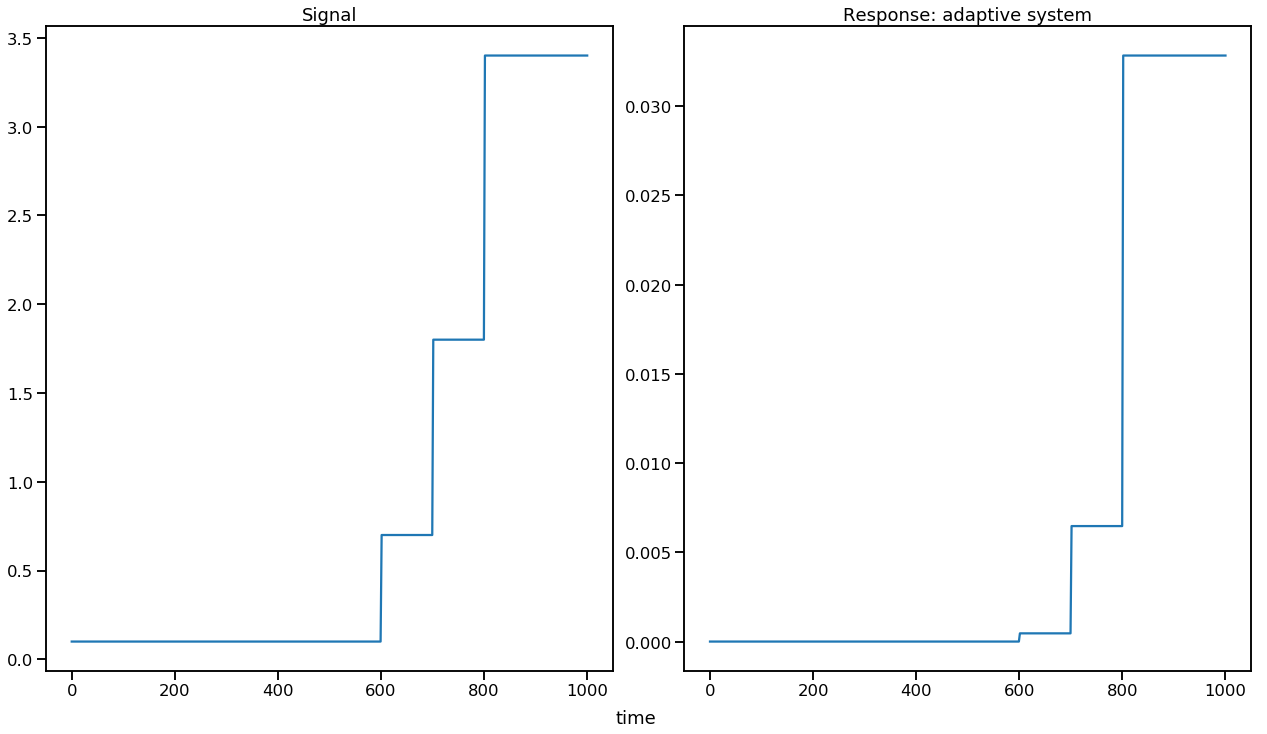

In [9]:
if motif.value == 'basal homeostat':
    sol = odeint(homeostat, 0, signal.signal, args=(k1.value, Kd.value, n.value))
elif motif.value == 'signal limiter':
    sol = odeint(signal_limiter, 0, signal.signal, args=(k1.value, n.value))
elif motif.value == 'adaptive system':
    sol = odeint(adaptive_system, [0,0], signal.signal, args=(k1.value, n.value, tau.value))
    sol = sol[:,0]
elif motif.value == 'transient generator':
    sol = odeint(homeostat, [0,0], signal.signal, args=(k1.value, n.value, tau.value))
    sol = sol[:,0]

fig, axes = plt.subplots(1, 2, figsize = (18, 10), sharey=False)
fig.tight_layout()   

axes[0].plot(signal.time, signal.signal)
axes[0].set_title('Signal')

axes[1].plot(signal.time, sol)
axes[1].set_title('Response: {}'.format(motif.value))

fig.text(0.5, 0, 'time', ha='center', va='center')
fig.text(0.06, 0.5, '', ha='center', va='center', rotation='vertical')

plt.show()